## Speech Emotion Detection

#### RAVDESS Dataset:

- The Ryerson Audio-Visual Database of Emotional Speech and Song (RAVDESS) is licensed under CC BY-NA-SC 4.0. and can be downloaded free of charge at https://zenodo.org/record/1188976.
- The Ryerson Audio-Visual Database of Emotional Speech and Song (RAVDESS) contains 7356 files (total size: 24.8 GB). 
- The database contains 24 professional actors (12 female, 12 male), vocalizing two lexically-matched statements in a neutral North American accent. 
- Speech includes calm, happy, sad, angry, fearful, surprise, and disgust expressions, and song contains calm, happy, sad, angry, and fearful emotions. 
- Each expression is produced at two levels of emotional intensity (normal, strong), with an additional neutral expression. - All conditions are available in three modality formats: Audio-only (16bit, 48kHz .wav), Audio-Video (720p H.264, AAC 48kHz, .mp4), and Video-only (no sound).  

For this analysis, the below file types have been used:
- Audio speech files. 
- Additionally, the speech from the video files have been extracted by converting the MP4 files to WAV format.

File naming convention: Each of the 7356 RAVDESS files has a unique filename. The filename consists of a 7-part numerical identifier (e.g., 02-01-06-01-02-01-12.mp4). These identifiers define the stimulus characteristics: 

Filename identifiers 
- Modality (01 = full-AV, 02 = video-only, 03 = audio-only).
- Vocal channel (01 = speech, 02 = song).
- Emotion (01 = neutral, 02 = calm, 03 = happy, 04 = sad, 05 = angry, 06 = fearful, 07 = disgust, 08 = surprised).
- Emotional intensity (01 = normal, 02 = strong). NOTE: There is no strong intensity for the 'neutral' emotion.
- Statement (01 = "Kids are talking by the door", 02 = "Dogs are sitting by the door").
- Repetition (01 = 1st repetition, 02 = 2nd repetition).
- Actor (01 to 24. Odd numbered actors are male, even numbered actors are female).

In [1]:
# Import libraries 
import librosa
import numpy as np
import matplotlib.pyplot as plt
import tensorflow as tf
from matplotlib.pyplot import specgram
import pandas as pd
import glob 
from sklearn.metrics import confusion_matrix
import IPython.display as ipd  
import os
import sys
import warnings
import subprocess

from sklearn.model_selection import train_test_split
from sklearn.tree import DecisionTreeClassifier
from sklearn.metrics import classification_report,confusion_matrix, accuracy_score
from sklearn.model_selection import GridSearchCV
from sklearn.ensemble import RandomForestClassifier
from xgboost import XGBClassifier

import keras
from keras.models import Sequential
from keras.layers import Dense
from keras.layers import Input, Flatten, Dropout, Activation, BatchNormalization
from keras.layers import Conv1D, MaxPooling1D
from keras.models import Model

if not sys.warnoptions:
    warnings.simplefilter("ignore")
warnings.filterwarnings("ignore", category=DeprecationWarning) 


C:\Users\sdevi\AppData\Local\Continuum\anaconda3\lib\site-packages\tensorflow\python\framework\dtypes.py:526: FutureWarning: Passing (type, 1) or '1type' as a synonym of type is deprecated; in a future version of numpy, it will be understood as (type, (1,)) / '(1,)type'.
  _np_qint8 = np.dtype([("qint8", np.int8, 1)])
C:\Users\sdevi\AppData\Local\Continuum\anaconda3\lib\site-packages\tensorflow\python\framework\dtypes.py:527: FutureWarning: Passing (type, 1) or '1type' as a synonym of type is deprecated; in a future version of numpy, it will be understood as (type, (1,)) / '(1,)type'.
  _np_quint8 = np.dtype([("quint8", np.uint8, 1)])
C:\Users\sdevi\AppData\Local\Continuum\anaconda3\lib\site-packages\tensorflow\python\framework\dtypes.py:528: FutureWarning: Passing (type, 1) or '1type' as a synonym of type is deprecated; in a future version of numpy, it will be understood as (type, (1,)) / '(1,)type'.
  _np_qint16 = np.dtype([("qint16", np.int16, 1)])
C:\Users\sdevi\AppData\Local\Conti

In [2]:
# Define a function to convert the video files(MP4 format) to audio files(WAV format)

def fn_ConvertMP4ToWAV(v_path_VideoFiles, v_path_ConvertedVideoFiles):
    """ Convert MP4 video files to WAV audio files. """
    for root, dirs, files in os.walk(v_path_VideoFiles, topdown=False):        
        for name in files:            
            # Remove files that do not have audio
            if not name.startswith('02'):
                
                command = 'ffmpeg -i ' + root + '\\' + name + ' ' + '-ab 160k -ac 2 -ar 44100 -vn' + ' ' + v_path_ConvertedVideoFiles + '\\' + name[:-3] + 'wav'            
                subprocess.call(command, shell=True)

In [3]:
# Define the path variables

path_AudioFiles = 'D:\Data_SpeechEmotionRecognition\Data\AudioFiles'
path_VideoFiles = "D:\Data_SpeechEmotionRecognition\Data\VideoFiles\VideoSourceFiles"
path_ConvertedVideoFiles = 'D:\Data_SpeechEmotionRecognition\Data\VideoFiles\ConvertedFolder'

In [4]:
# Call fn_ConvertMP4ToWAV to convert MP4 video files to WAV audio files

% time fn_ConvertMP4ToWAV(path_VideoFiles, path_ConvertedVideoFiles)

Wall time: 24min 48s


### Explore the Data

In [5]:
# Define a function to play the audion track and plot the audio wave and MFCC.

def fn_PlayAudio_PlotAudioWave_PlotMFCC(v_file):
    """Play and plot the audio wave and MFCC for a given audio track"""
    
    # Play the audio 
    ipd.Audio(v_file)

    # Plot the audio wave
    data, sampling_rate = librosa.load(v_file)
    plt.figure(figsize=(15, 5))
    librosa.display.waveplot(data, sr=sampling_rate)
    
    X, sample_rate = librosa.load(v_file, res_type='kaiser_fast')  
    mfcc = librosa.feature.mfcc(y=X, sr=sample_rate, n_mfcc=40) 

    # Plot the MFCC
    plt.figure(figsize=(20, 15))
    plt.subplot(3,1,1)
    librosa.display.specshow(mfcc, x_axis='time')
    plt.ylabel('MFCC')
    plt.colorbar()

    return ipd.Audio(v_file)

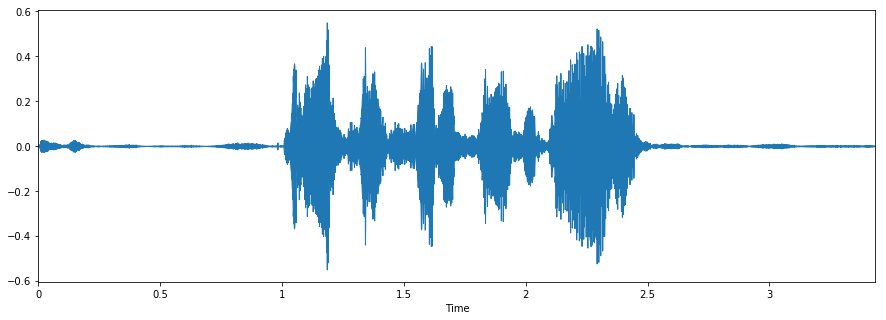

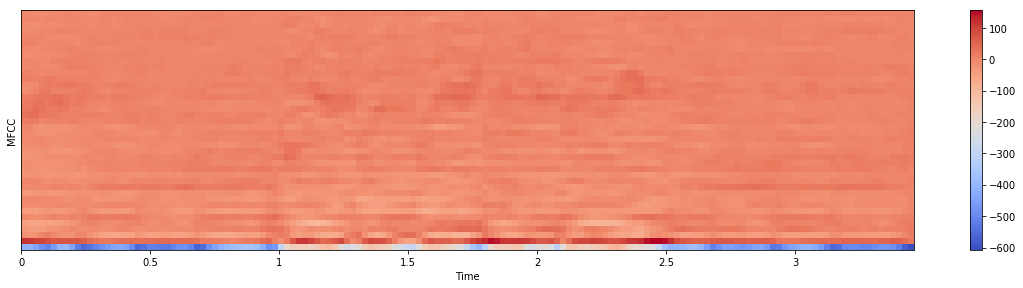

In [6]:
# Play the audio for a fearful track and plot the audio wave and MFCC for the same 
file = path_AudioFiles + '\\Actor_03\\03-01-06-02-02-02-03.wav'  

fn_PlayAudio_PlotAudioWave_PlotMFCC(file)

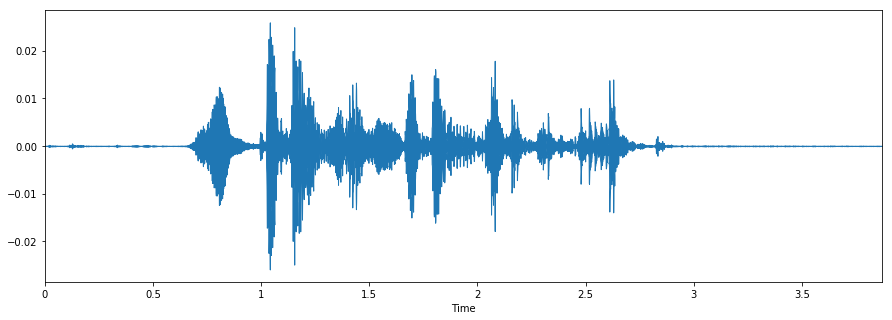

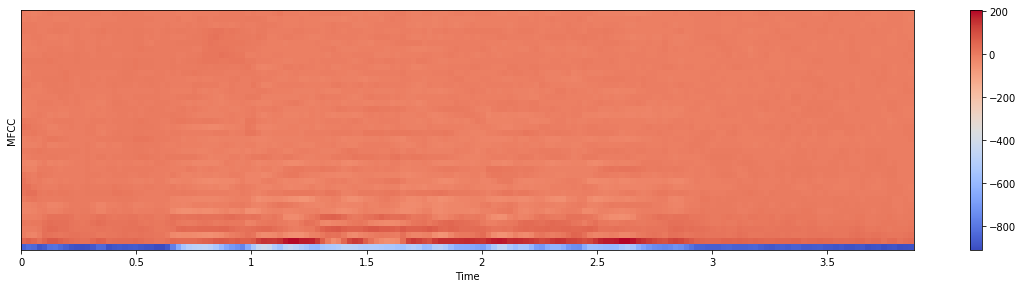

In [7]:
# Play the audio for a sad track and plot the audio wave and MFCC for the same

file = path_AudioFiles + '\\Actor_09\\03-01-04-02-02-02-09.wav'  

fn_PlayAudio_PlotAudioWave_PlotMFCC(file)

In [8]:
# Define a function to compare the audio tracks and plot their waves

def fn_CompareAudio_Plot(v_Path1, v_Path2, v_label1, v_label2):
    """Compare 2 audio tracks and plot them"""

    i = 0
    mfcc = {}
    for path in [v_Path1, v_Path2]:
        X, sample_rate = librosa.load(path, res_type='kaiser_fast')  
        mfcc[i] = np.mean(librosa.feature.mfcc(y=X, sr=sample_rate, n_mfcc=10), axis=0)
        i = i + 1

    # Audio wave
    plt.figure(figsize=(20, 15))
    plt.subplot(3,1,1)
    plt.plot(mfcc[0], label=v_label1)
    plt.plot(mfcc[1], label=v_label2)
    plt.legend()

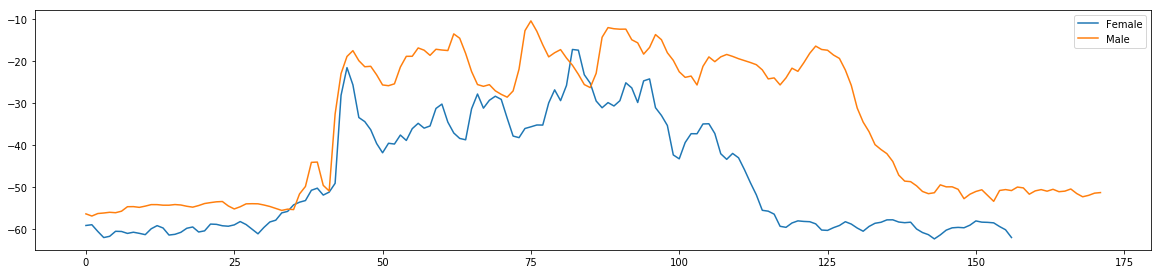

In [9]:
# Compare audio files of male and feamale tracks with same emotion

# Emotion: Angry, Gender: Female 
path_1 = path_AudioFiles + "\\Actor_08\\03-01-05-02-02-02-08.wav"

# Emotion: Angry, Gender: Male 
path_2 = path_AudioFiles + "\\Actor_09\\03-01-05-02-02-02-09.wav"

fn_CompareAudio_Plot(path_1, path_2, 'Female', 'Male')

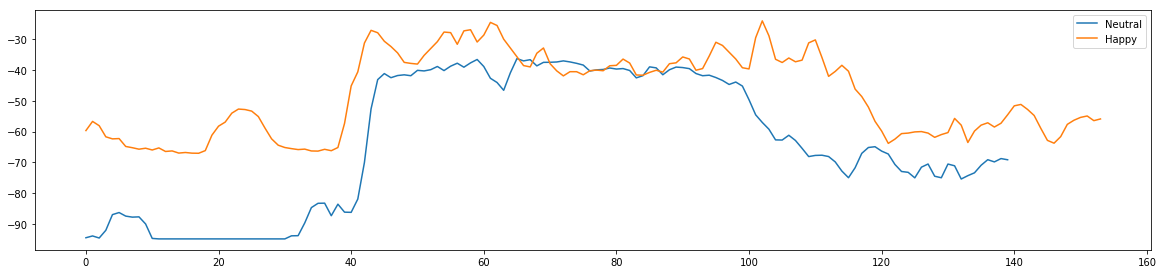

In [10]:
# Compare audio files of different emotions of same actor

# Emotion: Neutral, Actor: Actor09 
path_1 = path_AudioFiles + "\\Actor_09\\03-01-01-01-02-02-09.wav"

# Emotion: Happy, Actor: Actor09
path_2 = path_AudioFiles + "\\Actor_09\\03-01-03-02-02-02-09.wav"

fn_CompareAudio_Plot(path_1, path_2, 'Neutral', 'Happy')

In [11]:
# Define a function to generate MFCC from the audio files

def fn_MFCC_Emotion(v_path_AudioFiles, v_path_ConvertedVideoFiles):
    "Feature Generation: MFCC and Emotion"
    for path in [v_path_AudioFiles, v_path_ConvertedVideoFiles]:
        for root, dirs, files in os.walk(path):
            for name in files:

                X, sample_rate = librosa.load(os.path.join(str(root),str(name)), res_type='kaiser_fast')  
                v_mfcc = np.mean(librosa.feature.mfcc(y=X, sr=sample_rate, n_mfcc=40).T,axis=0) 

                v_emotion = int(name[7:8]) - 1 
                
                lst_mfcc.append(v_mfcc)
                lst_emotion.append(v_emotion)
    return lst_mfcc, lst_emotion

In [12]:
# Call fn_MFCC_Emotion to generate MFCC and Emotion features

lst_mfcc = []
lst_emotion = []

%time mfcc, emotion =  fn_MFCC_Emotion(path_AudioFiles, path_ConvertedVideoFiles)

print(mfcc[0:3], emotion[0:3])

X = np.array(mfcc)
y = np.array(emotion)

print(X.shape, y.shape)

Wall time: 2min 10s
[array([-7.0039862e+02,  5.8630196e+01, -3.0258517e+00,  1.6040239e+01,
        4.2485290e+00,  3.8699336e+00, -6.3817191e+00, -1.8863522e-01,
       -1.3735003e+01, -3.1972364e-01, -1.4757471e+00, -9.8867583e-01,
        1.5016697e-01, -2.1724679e+00, -8.8929641e-01,  1.8827372e+00,
       -4.9570909e+00, -1.1768675e+00, -1.8201358e+00, -5.9608293e-01,
       -6.1165876e+00, -4.7533545e-01, -2.2442930e+00, -4.7243538e+00,
       -1.3839185e+00, -1.1956732e+00, -4.4132257e+00, -2.4823302e-01,
       -1.5963907e+00, -4.4708246e-01, -1.4113584e+00, -2.7697709e+00,
       -2.0420086e+00, -2.5226631e+00, -2.5074482e+00, -2.2504985e+00,
       -3.8150659e-01, -2.4810598e+00, -2.7910228e+00, -2.2448652e+00],
      dtype=float32), array([-6.9555786e+02,  5.9240166e+01, -5.3727751e+00,  1.9776365e+01,
        5.2003880e+00,  3.3246305e+00, -4.6684065e+00, -2.1939754e+00,
       -1.4508072e+01,  1.3079028e+00, -1.5743595e+00, -4.6489701e-01,
       -9.1644311e-01, -1.5777048

In [13]:
# Split the data into train and test data
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.3, random_state=9)

### Model 1: Decision Tree

In [14]:
dt = DecisionTreeClassifier(criterion='entropy', max_depth=10, min_samples_leaf = 3, 
                                 random_state= 9)

%time dt.fit(X_train, y_train)

Wall time: 210 ms


DecisionTreeClassifier(class_weight=None, criterion='entropy', max_depth=10,
                       max_features=None, max_leaf_nodes=None,
                       min_impurity_decrease=0.0, min_impurity_split=None,
                       min_samples_leaf=3, min_samples_split=2,
                       min_weight_fraction_leaf=0.0, presort=False,
                       random_state=9, splitter='best')

In [15]:
dt.fit(X_train, y_train)
y_pred = dt.predict(X_test)

print(classification_report(y_test,y_pred))

              precision    recall  f1-score   support

           0       0.56      0.50      0.53        70
           1       0.64      0.74      0.69       115
           2       0.50      0.54      0.52       113
           3       0.61      0.61      0.61       102
           4       0.58      0.63      0.60       101
           5       0.69      0.57      0.62       123
           6       0.62      0.40      0.49       117
           7       0.45      0.56      0.50       126

    accuracy                           0.57       867
   macro avg       0.58      0.57      0.57       867
weighted avg       0.58      0.57      0.57       867



### Model 2: Random Forest

In [16]:
rf = RandomForestClassifier(criterion="gini", max_depth=10, max_features="sqrt", 
                                 max_leaf_nodes = 100, min_samples_leaf = 3, min_samples_split = 20, 
                                 n_estimators= 20000, random_state= 9)

%time rf.fit(X_train, y_train)

Wall time: 2min 19s


RandomForestClassifier(bootstrap=True, class_weight=None, criterion='gini',
                       max_depth=10, max_features='sqrt', max_leaf_nodes=100,
                       min_impurity_decrease=0.0, min_impurity_split=None,
                       min_samples_leaf=3, min_samples_split=20,
                       min_weight_fraction_leaf=0.0, n_estimators=20000,
                       n_jobs=None, oob_score=False, random_state=9, verbose=0,
                       warm_start=False)

In [17]:
y_pred = rf.predict(X_test)

print(classification_report(y_test,y_pred))

              precision    recall  f1-score   support

           0       0.89      0.36      0.51        70
           1       0.64      0.97      0.77       115
           2       0.82      0.82      0.82       113
           3       0.70      0.71      0.70       102
           4       0.88      0.81      0.85       101
           5       0.87      0.80      0.84       123
           6       0.77      0.73      0.75       117
           7       0.74      0.78      0.76       126

    accuracy                           0.77       867
   macro avg       0.79      0.75      0.75       867
weighted avg       0.78      0.77      0.76       867



### Model 3: XGBoost

In [18]:
XGB = XGBClassifier(n_estimators=2000, gamma=0.5,learning_rate=0.1, max_depth = 10)

%time XGB.fit(X_train, y_train)

Wall time: 4min 14s


XGBClassifier(base_score=0.5, booster='gbtree', colsample_bylevel=1,
              colsample_bytree=1, gamma=0.5, learning_rate=0.1,
              max_delta_step=0, max_depth=10, min_child_weight=1, missing=None,
              n_estimators=2000, n_jobs=1, nthread=None,
              objective='multi:softprob', random_state=0, reg_alpha=0,
              reg_lambda=1, scale_pos_weight=1, seed=None, silent=True,
              subsample=1)

In [19]:
y_pred = XGB.predict(X_test)

print(classification_report(y_test,y_pred))

              precision    recall  f1-score   support

           0       0.82      0.87      0.85        70
           1       0.86      0.90      0.88       115
           2       0.92      0.93      0.93       113
           3       0.79      0.81      0.80       102
           4       0.89      0.89      0.89       101
           5       0.92      0.92      0.92       123
           6       0.88      0.87      0.88       117
           7       0.92      0.83      0.88       126

    accuracy                           0.88       867
   macro avg       0.88      0.88      0.88       867
weighted avg       0.88      0.88      0.88       867



### Model 4: CNN (Convolutional  Neural Network)

In [20]:
X_train = np.expand_dims(X_train, axis=2)
X_test = np.expand_dims(X_test, axis=2)

X_train.shape, X_test.shape

((2020, 40, 1), (867, 40, 1))

In [21]:
model = Sequential()
model.add(Conv1D(256, 8, padding='same',input_shape=(X_train.shape[1],1))) 
model.add(Activation('relu'))
model.add(Conv1D(256, 8, padding='same'))
model.add(BatchNormalization())
model.add(Activation('relu'))
model.add(Dropout(0.25))
model.add(MaxPooling1D(pool_size=(4)))
model.add(Conv1D(128, 8, padding='same'))
model.add(Activation('relu'))
model.add(Conv1D(128, 8, padding='same'))
model.add(Activation('relu'))
model.add(Conv1D(128, 8, padding='same'))
model.add(Activation('relu'))
model.add(Conv1D(128, 8, padding='same'))
model.add(BatchNormalization())
model.add(Activation('relu'))
model.add(Dropout(0.25))
model.add(MaxPooling1D(pool_size=(4)))
model.add(Conv1D(64, 8, padding='same'))
model.add(Activation('relu'))
model.add(Conv1D(64, 8, padding='same'))
model.add(Activation('relu'))
model.add(Flatten())
model.add(Dense(8)) 
model.add(Activation('softmax'))
opt = keras.optimizers.rmsprop(lr=0.00001, decay=1e-6)

Using TensorFlow backend.


Instructions for updating:
Colocations handled automatically by placer.
Instructions for updating:
Please use `rate` instead of `keep_prob`. Rate should be set to `rate = 1 - keep_prob`.


In [22]:
model.summary()

_________________________________________________________________
Layer (type)                 Output Shape              Param #   
conv1d_1 (Conv1D)            (None, 40, 256)           2304      
_________________________________________________________________
activation_1 (Activation)    (None, 40, 256)           0         
_________________________________________________________________
conv1d_2 (Conv1D)            (None, 40, 256)           524544    
_________________________________________________________________
batch_normalization_1 (Batch (None, 40, 256)           1024      
_________________________________________________________________
activation_2 (Activation)    (None, 40, 256)           0         
_________________________________________________________________
dropout_1 (Dropout)          (None, 40, 256)           0         
_________________________________________________________________
max_pooling1d_1 (MaxPooling1 (None, 10, 256)           0         
__________

In [23]:
model.compile(loss='sparse_categorical_crossentropy',
              optimizer=opt,
              metrics=['accuracy'])

In [33]:
%time cnn=model.fit(X_train, y_train, batch_size=16, epochs=1000, validation_data=(X_test, y_test))

Train on 2020 samples, validate on 867 samples
Epoch 1/1000
2020/2020 [==============================] - 16s 8ms/step - loss: 0.0100 - acc: 0.9975 - val_loss: 0.5678 - val_acc: 0.8916
Epoch 2/1000
2020/2020 [==============================] - 19s 9ms/step - loss: 0.0047 - acc: 0.9980 - val_loss: 0.4811 - val_acc: 0.8973o - ETA: 2s - los
Epoch 3/1000
2020/2020 [==============================] - 17s 9ms/step - loss: 0.0073 - acc: 0.9975 - val_loss: 0.5843 - val_acc: 0.8893
Epoch 4/1000
2020/2020 [==============================] - 21s 11ms/step - loss: 0.0033 - acc: 0.9990 - val_loss: 0.5261 - val_acc: 0.8962
Epoch 5/1000
2020/2020 [==============================] - 21s 10ms/step - loss: 0.0082 - acc: 0.9985 - val_loss: 0.5012 - val_acc: 0.9008
Epoch 6/1000
2020/2020 [==============================] - 17s 8ms/step - loss: 0.0090 - acc: 0.9970 - val_loss: 0.5420 - val_acc: 0.8950
Epoch 7/1000
2020/2020 [==============================] - 21s 10ms/step - loss: 0.0053 - acc: 0.9990 - val_loss:

Epoch 118/1000
2020/2020 [==============================] - 16s 8ms/step - loss: 0.0040 - acc: 0.9985 - val_loss: 0.5031 - val_acc: 0.9054
Epoch 119/1000
2020/2020 [==============================] - 21s 10ms/step - loss: 0.0011 - acc: 1.0000 - val_loss: 0.4953 - val_acc: 0.9089
Epoch 120/1000
2020/2020 [==============================] - 18s 9ms/step - loss: 0.0046 - acc: 0.9985 - val_loss: 0.5653 - val_acc: 0.8997
Epoch 121/1000
2020/2020 [==============================] - 19s 9ms/step - loss: 0.0034 - acc: 0.9985 - val_loss: 0.5508 - val_acc: 0.9077
Epoch 122/1000
2020/2020 [==============================] - 21s 10ms/step - loss: 0.0024 - acc: 0.9995 - val_loss: 0.5241 - val_acc: 0.9066
Epoch 123/1000
2020/2020 [==============================] - 16s 8ms/step - loss: 0.0095 - acc: 0.9965 - val_loss: 0.5455 - val_acc: 0.8997
Epoch 124/1000
2020/2020 [==============================] - 21s 10ms/step - loss: 0.0012 - acc: 0.9995 - val_loss: 0.5111 - val_acc: 0.9020
Epoch 125/1000
2020/2020

Epoch 235/1000
2020/2020 [==============================] - 19s 10ms/step - loss: 0.0043 - acc: 0.9985 - val_loss: 0.5234 - val_acc: 0.9146
Epoch 236/1000
2020/2020 [==============================] - 15s 7ms/step - loss: 0.0041 - acc: 0.9980 - val_loss: 0.5641 - val_acc: 0.8973
Epoch 237/1000
2020/2020 [==============================] - 20s 10ms/step - loss: 0.0024 - acc: 0.9995 - val_loss: 0.5725 - val_acc: 0.9043
Epoch 238/1000
2020/2020 [==============================] - 17s 8ms/step - loss: 0.0020 - acc: 0.9990 - val_loss: 0.5102 - val_acc: 0.9100
Epoch 239/1000
2020/2020 [==============================] - 17s 9ms/step - loss: 0.0013 - acc: 1.0000 - val_loss: 0.5849 - val_acc: 0.8939
Epoch 240/1000
2020/2020 [==============================] - 20s 10ms/step - loss: 0.0054 - acc: 0.9995 - val_loss: 0.5537 - val_acc: 0.9089
Epoch 241/1000
2020/2020 [==============================] - 15s 7ms/step - loss: 0.0018 - acc: 0.9995 - val_loss: 0.5697 - val_acc: 0.9135
Epoch 242/1000
2020/2020

2020/2020 [==============================] - 28s 14ms/step - loss: 0.0023 - acc: 0.9995 - val_loss: 0.6313 - val_acc: 0.8985
Epoch 352/1000
2020/2020 [==============================] - 26s 13ms/step - loss: 0.0029 - acc: 0.9985 - val_loss: 0.5426 - val_acc: 0.9112
Epoch 353/1000
2020/2020 [==============================] - 28s 14ms/step - loss: 0.0048 - acc: 0.9985 - val_loss: 0.5925 - val_acc: 0.9031
Epoch 354/1000
2020/2020 [==============================] - 26s 13ms/step - loss: 0.0024 - acc: 0.9990 - val_loss: 0.6635 - val_acc: 0.8973
Epoch 355/1000
2020/2020 [==============================] - 26s 13ms/step - loss: 0.0014 - acc: 1.0000 - val_loss: 0.5779 - val_acc: 0.9066
Epoch 356/1000
2020/2020 [==============================] - 25s 12ms/step - loss: 0.0023 - acc: 0.9995 - val_loss: 0.5657 - val_acc: 0.9089
Epoch 357/1000
2020/2020 [==============================] - 27s 13ms/step - loss: 0.0029 - acc: 0.9985 - val_loss: 0.5403 - val_acc: 0.9066
Epoch 358/1000
2020/2020 [=========

2020/2020 [==============================] - 15s 8ms/step - loss: 0.0037 - acc: 0.9985 - val_loss: 0.5978 - val_acc: 0.8973
Epoch 475/1000
2020/2020 [==============================] - 16s 8ms/step - loss: 0.0015 - acc: 0.9995 - val_loss: 0.5864 - val_acc: 0.9054
Epoch 476/1000
2020/2020 [==============================] - 21s 10ms/step - loss: 0.0037 - acc: 0.9980 - val_loss: 0.5314 - val_acc: 0.9100
Epoch 477/1000
2020/2020 [==============================] - 23s 12ms/step - loss: 0.0034 - acc: 0.9995 - val_loss: 0.5699 - val_acc: 0.9031
Epoch 478/1000
2020/2020 [==============================] - 20s 10ms/step - loss: 0.0058 - acc: 0.9985 - val_loss: 0.5645 - val_acc: 0.9112
Epoch 479/1000
2020/2020 [==============================] - 20s 10ms/step - loss: 0.0014 - acc: 0.9995 - val_loss: 0.5723 - val_acc: 0.9077
Epoch 480/1000
2020/2020 [==============================] - 19s 9ms/step - loss: 0.0020 - acc: 0.9995 - val_loss: 0.6412 - val_acc: 0.8973
Epoch 481/1000
2020/2020 [============

2020/2020 [==============================] - 20s 10ms/step - loss: 0.0012 - acc: 0.9995 - val_loss: 0.6024 - val_acc: 0.9066
Epoch 591/1000
2020/2020 [==============================] - 25s 12ms/step - loss: 0.0017 - acc: 0.9995 - val_loss: 0.5907 - val_acc: 0.9066
Epoch 592/1000
2020/2020 [==============================] - 20s 10ms/step - loss: 0.0012 - acc: 0.9995 - val_loss: 0.6107 - val_acc: 0.9054
Epoch 593/1000
2020/2020 [==============================] - 19s 9ms/step - loss: 9.7982e-04 - acc: 1.0000 - val_loss: 0.5909 - val_acc: 0.9112
Epoch 594/1000
2020/2020 [==============================] - 22s 11ms/step - loss: 0.0020 - acc: 0.9990 - val_loss: 0.5811 - val_acc: 0.9100
Epoch 595/1000
2020/2020 [==============================] - 20s 10ms/step - loss: 0.0014 - acc: 0.9990 - val_loss: 0.6245 - val_acc: 0.9112
Epoch 596/1000
2020/2020 [==============================] - 21s 11ms/step - loss: 0.0013 - acc: 0.9990 - val_loss: 0.6837 - val_acc: 0.9031
Epoch 597/1000
2020/2020 [======

2020/2020 [==============================] - 20s 10ms/step - loss: 0.0011 - acc: 0.9995 - val_loss: 0.6056 - val_acc: 0.9043
Epoch 715/1000
2020/2020 [==============================] - 18s 9ms/step - loss: 3.7466e-04 - acc: 1.0000 - val_loss: 0.6469 - val_acc: 0.8985
Epoch 716/1000
2020/2020 [==============================] - 18s 9ms/step - loss: 0.0018 - acc: 0.9995 - val_loss: 0.5922 - val_acc: 0.9112
Epoch 717/1000
2020/2020 [==============================] - 20s 10ms/step - loss: 2.6703e-04 - acc: 1.0000 - val_loss: 0.6180 - val_acc: 0.9054
Epoch 718/1000
2020/2020 [==============================] - 23s 11ms/step - loss: 5.2823e-04 - acc: 1.0000 - val_loss: 0.5890 - val_acc: 0.9100
Epoch 719/1000
2020/2020 [==============================] - 18s 9ms/step - loss: 0.0014 - acc: 0.9995 - val_loss: 0.5966 - val_acc: 0.9089
Epoch 720/1000
2020/2020 [==============================] - 15s 7ms/step - loss: 0.0013 - acc: 0.9995 - val_loss: 0.6214 - val_acc: 0.9123
Epoch 721/1000
2020/2020 [=

2020/2020 [==============================] - 17s 8ms/step - loss: 0.0048 - acc: 0.9995 - val_loss: 0.6371 - val_acc: 0.8962
Epoch 773/1000
2020/2020 [==============================] - 23s 11ms/step - loss: 4.0919e-04 - acc: 1.0000 - val_loss: 0.6473 - val_acc: 0.8985
Epoch 774/1000
2020/2020 [==============================] - 31s 15ms/step - loss: 0.0034 - acc: 0.9990 - val_loss: 0.6192 - val_acc: 0.9043
Epoch 775/1000
2020/2020 [==============================] - 29s 15ms/step - loss: 2.2334e-04 - acc: 1.0000 - val_loss: 0.6159 - val_acc: 0.9054
Epoch 776/1000
2020/2020 [==============================] - 16s 8ms/step - loss: 0.0047 - acc: 0.9990 - val_loss: 0.6262 - val_acc: 0.9008
Epoch 777/1000
2020/2020 [==============================] - 21s 10ms/step - loss: 0.0023 - acc: 0.9995 - val_loss: 0.6532 - val_acc: 0.9031
Epoch 778/1000
2020/2020 [==============================] - 22s 11ms/step - loss: 0.0020 - acc: 0.9995 - val_loss: 0.6352 - val_acc: 0.9089
Epoch 779/1000
2020/2020 [===

Epoch 842/1000
2020/2020 [==============================] - 22s 11ms/step - loss: 0.0042 - acc: 0.9995 - val_loss: 0.6402 - val_acc: 0.9100
Epoch 843/1000
2020/2020 [==============================] - 16s 8ms/step - loss: 6.1286e-04 - acc: 0.9995 - val_loss: 0.5970 - val_acc: 0.9123
Epoch 844/1000
2020/2020 [==============================] - 16s 8ms/step - loss: 8.2261e-04 - acc: 0.9995 - val_loss: 0.5583 - val_acc: 0.9170
Epoch 845/1000
2020/2020 [==============================] - 18s 9ms/step - loss: 1.9931e-04 - acc: 1.0000 - val_loss: 0.6214 - val_acc: 0.9089
Epoch 846/1000
2020/2020 [==============================] - 17s 9ms/step - loss: 3.1507e-04 - acc: 1.0000 - val_loss: 0.6598 - val_acc: 0.9077
Epoch 847/1000
2020/2020 [==============================] - 17s 8ms/step - loss: 1.3723e-04 - acc: 1.0000 - val_loss: 0.6251 - val_acc: 0.9008
Epoch 848/1000
2020/2020 [==============================] - 15s 7ms/step - loss: 6.8270e-04 - acc: 0.9995 - val_loss: 0.5833 - val_acc: 0.9170
Ep

2020/2020 [==============================] - 20s 10ms/step - loss: 0.0021 - acc: 0.9995 - val_loss: 0.5512 - val_acc: 0.9216
Epoch 971/1000
2020/2020 [==============================] - 20s 10ms/step - loss: 0.0013 - acc: 0.9995 - val_loss: 0.5998 - val_acc: 0.9100
Epoch 972/1000
2020/2020 [==============================] - 21s 10ms/step - loss: 0.0024 - acc: 0.9990 - val_loss: 0.6150 - val_acc: 0.9123
Epoch 973/1000
2020/2020 [==============================] - 18s 9ms/step - loss: 7.3868e-05 - acc: 1.0000 - val_loss: 0.6029 - val_acc: 0.9181
Epoch 974/1000
2020/2020 [==============================] - 16s 8ms/step - loss: 0.0018 - acc: 0.9990 - val_loss: 0.6262 - val_acc: 0.9204
Epoch 975/1000
2020/2020 [==============================] - 21s 11ms/step - loss: 0.0019 - acc: 0.9990 - val_loss: 0.6122 - val_acc: 0.9123
Epoch 976/1000
2020/2020 [==============================] - 20s 10ms/step - loss: 7.2411e-04 - acc: 0.9995 - val_loss: 0.6089 - val_acc: 0.9077
Epoch 977/1000
2020/2020 [===

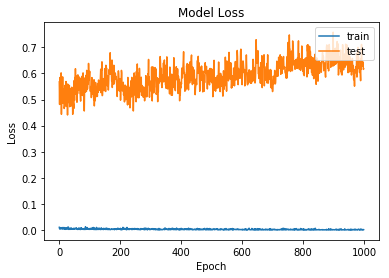

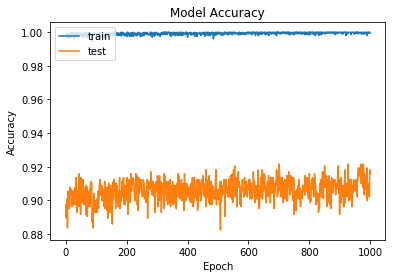

In [34]:
# Plot the model loss and accuracy 

plt.plot(cnn.history['loss'])
plt.plot(cnn.history['val_loss'])
plt.title('Model Loss')
plt.ylabel('Loss')
plt.xlabel('Epoch')
plt.legend(['train', 'test'], loc='upper right')
plt.show()

plt.plot(cnn.history['acc'])
plt.plot(cnn.history['val_acc'])
plt.title('Model Accuracy')
plt.ylabel('Accuracy')
plt.xlabel('Epoch')
plt.legend(['train', 'test'], loc='upper left')
plt.show()

In [36]:
y_pred = model.predict_classes(X_test)

In [37]:
print(classification_report(y_test, y_pred))

              precision    recall  f1-score   support

           0       0.89      0.91      0.90        70
           1       0.96      0.90      0.93       115
           2       0.95      0.96      0.96       113
           3       0.93      0.84      0.89       102
           4       0.80      0.99      0.88       101
           5       0.98      0.93      0.96       123
           6       0.88      0.90      0.89       117
           7       0.93      0.89      0.91       126

    accuracy                           0.92       867
   macro avg       0.92      0.92      0.91       867
weighted avg       0.92      0.92      0.92       867



In [38]:
print(confusion_matrix(y_test, y_pred))

# 0 = neutral, 1 = calm, 2 = happy, 3 = sad, 4 = angry, 5 = fearful, 6 = disgust, 7 = surprised

[[ 64   2   2   0   0   0   2   0]
 [  8 103   0   2   0   0   2   0]
 [  0   0 109   0   2   0   0   2]
 [  0   2   4  86   2   2   4   2]
 [  0   0   0   0 100   0   1   0]
 [  0   0   0   0   7 115   1   0]
 [  0   0   0   2   6   0 105   4]
 [  0   0   0   2   8   0   4 112]]


####                                                                                THANK YOU !!